In [1]:
cd /content/drive/My Drive/Colab Notebooks/srgan

/content/drive/My Drive/Colab Notebooks/srgan


In [2]:
import os
import numpy as np
import math
import itertools
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

from models import *
from datasets import *

import torch.nn as nn
import torch.nn.functional as F
import torch

In [3]:
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

In [4]:
cfg = {}
cfg["epoch"] = 0
cfg["n_epochs"] = 20
cfg["dataset_name"] = "/content/drive/My Drive/Colab Notebooks/srgan/archive/training_data/training_data/images"
cfg["batch_size"] = 4
cfg["lr"] = 0.0002
cfg["b1"] = 0.5
cfg['b2'] = 0.999
cfg["decay_epoch"] = 100
cfg["n_cpu"] = 8
cfg["hr_height"] = 224
cfg["hr_width"] = 224
cfg["channels"] = 3
cfg["sample_interval"] = 100
cfg["checkpoint_interval"] = 5
cfg

{'b1': 0.5,
 'b2': 0.999,
 'batch_size': 4,
 'channels': 3,
 'checkpoint_interval': 5,
 'dataset_name': '/content/drive/My Drive/Colab Notebooks/srgan/archive/training_data/training_data/images',
 'decay_epoch': 100,
 'epoch': 0,
 'hr_height': 224,
 'hr_width': 224,
 'lr': 0.0002,
 'n_cpu': 8,
 'n_epochs': 20,
 'sample_interval': 100}

In [5]:
cuda = torch.cuda.is_available()

hr_shape = (cfg["hr_height"], cfg["hr_width"])

In [6]:
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(cfg["channels"], *hr_shape))
feature_extractor = FeatureExtractor()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [7]:
feature_extractor.eval()

FeatureExtractor(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3

In [8]:
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

In [9]:
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

In [10]:
if cfg["epoch"] != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/generator_%d.pth"))
    discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth"))

In [11]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=cfg["lr"], betas=(cfg["b1"], cfg["b2"]))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=cfg["lr"], betas=(cfg["b1"], cfg["b2"]))
scheduler_G = StepLR(optimizer_G, step_size=2e+5, gamma=0.1)
scheduler_D = StepLR(optimizer_D, step_size=2e+5, gamma=0.1)

In [12]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [14]:
dataloader = DataLoader(
    ImageDataset(cfg["dataset_name"], hr_shape=hr_shape),
    batch_size=cfg["batch_size"],
    shuffle=True,
    num_workers=cfg["n_cpu"],
)

In [15]:
loss_G_list_epoch = []
loss_D_list_epoch = []

for epoch in range(cfg["epoch"], cfg["n_epochs"]):
    epoch_G = []
    epoch_D = []
    for i, imgs in enumerate(dataloader):

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        epoch_G.append(loss_G.item())

        loss_G.backward()
        optimizer_G.step()
        scheduler_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        epoch_D.append(loss_D.item())

        loss_D.backward()
        optimizer_D.step()
        scheduler_D.step()

        # --------------
        #  Log Progress
        # --------------

        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, cfg["n_epochs"], i, len(dataloader), loss_D.item(), loss_G.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % cfg["sample_interval"] == 0:
            # Save image grid with upsampled inputs and SRGAN outputs
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_lr, gen_hr), -1)
            save_image(img_grid, "images/%d.png" % batches_done, normalize=False)

    if cfg["checkpoint_interval"] != -1 and (epoch+1) % cfg["checkpoint_interval"] == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "saved_models/generator_%d.pth" % (epoch+1))
        torch.save(discriminator.state_dict(), "saved_models/discriminator_%d.pth" % (epoch+1))

    loss_G_list_epoch.append(sum(epoch_G) / len(epoch_G))
    loss_D_list_epoch.append(sum(epoch_D) / len(epoch_D))

[Epoch 0/20] [Batch 0/937] [D loss: 0.672196] [G loss: 1.590361][Epoch 0/20] [Batch 1/937] [D loss: 1.262649] [G loss: 1.529948][Epoch 0/20] [Batch 2/937] [D loss: 0.585467] [G loss: 1.633320][Epoch 0/20] [Batch 3/937] [D loss: 0.681973] [G loss: 1.635368][Epoch 0/20] [Batch 4/937] [D loss: 0.545463] [G loss: 1.574938][Epoch 0/20] [Batch 5/937] [D loss: 0.434387] [G loss: 1.581918][Epoch 0/20] [Batch 6/937] [D loss: 0.443659] [G loss: 1.452735][Epoch 0/20] [Batch 7/937] [D loss: 0.397463] [G loss: 1.419337][Epoch 0/20] [Batch 8/937] [D loss: 0.332911] [G loss: 1.510420][Epoch 0/20] [Batch 9/937] [D loss: 0.281244] [G loss: 1.342507][Epoch 0/20] [Batch 10/937] [D loss: 0.286976] [G loss: 1.469489][Epoch 0/20] [Batch 11/937] [D loss: 0.270312] [G loss: 1.465166][Epoch 0/20] [Batch 12/937] [D loss: 0.254200] [G loss: 1.498663][Epoch 0/20] [Batch 13/937] [D loss: 0.232676] [G loss: 1.491730][Epoch 0/20] [Batch 14/937] [D loss: 0.223183] [G loss: 1.447170][Epoch 0/20] [Batch 15/937] [D loss

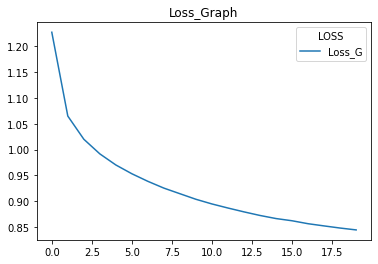

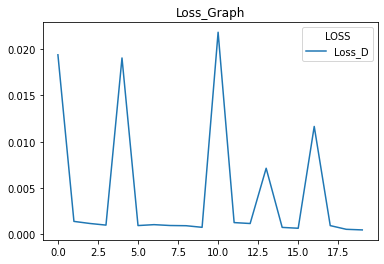

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Loss_Graph")
plt.plot(loss_G_list_epoch, label="Loss_G")
plt.legend(title='LOSS')
plt.show()

plt.title("Loss_Graph")
plt.plot(loss_D_list_epoch, label="Loss_D")
plt.legend(title='LOSS')
plt.show()